In [1]:
import os
import glob
import datetime

from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

2024-08-20 17:41:36.470991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 17:41:36.486491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 17:41:36.490553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-20 17:41:36.501950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-20 17:41:37.283739: W tensorflow/compiler/tf2

## Input Data

In [2]:
ds = xr.open_dataset("../data/dataset_no_overlap_60.nc")
ds

<xarray.Dataset> Size: 508MB
Dimensions:   (samples: 246, frequency: 127, time: 127, channels: 16)
Dimensions without coordinates: samples, frequency, time, channels
Data variables:
    features  (samples, frequency, time, channels) float64 508MB ...
    labels    (samples) int64 2kB ...

In [3]:
X_train, X_test, y_train, y_test = train_test_split(ds["features"].to_numpy(), ds["labels"].to_numpy(), test_size=0.33, random_state=22, stratify=ds["labels"])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((164, 127, 127, 16), (82, 127, 127, 16), (164,), (82,))

In [4]:
X_train_scaled = (X_train - X_train.mean(axis=(1, 2))[:, np.newaxis, np.newaxis, :]) / X_train.std(axis=(1, 2))[:, np.newaxis, np.newaxis, :]
X_test_scaled = (X_test - X_test.max(axis=(1, 2))[:, np.newaxis, np.newaxis, :]) / X_test.std(axis=(1, 2))[:, np.newaxis, np.newaxis, :]

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train)).shuffle(X_train.shape[0]).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test)).shuffle(X_test.shape[0]).batch(8).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1724150499.845486   33364 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150499.876036   33364 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150499.876101   33364 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150499.879734   33364 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724150499.879822   33364 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

## Create Model

In [6]:
inputs = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

x = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same")(inputs)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(2, 2), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, kernel_size=(2, 2), padding="same")(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 127, 127, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 63, 63, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 31, 31, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     7,373,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,387,745 (28.18 MB)

 Trainable params: 7,387,745 (28.18 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # loss=tf.keras.losses.BinaryFocalCrossentropy(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
])

In [9]:
log_dir = "logs/fit/" + "scaled-cwt-mexh-cnn-3-no-ovr-60" #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(train_ds, epochs=100, validation_data=test_ds, callbacks=[tensorboard_callback])
model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100


I0000 00:00:1724150504.103072   33596 service.cc:146] XLA service 0x7f2a180107d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724150504.103124   33596 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-20 17:41:44.182834: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-20 17:41:44.419022: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5638 - auc: 0.5624 - fn: 13.6429 - fp: 12.0000 - loss: 1.5502 - prc: 0.6410 - precision: 0.6124 - recall: 0.5783 - tn: 9.7143 - tp: 24.6429          

2024-08-20 17:41:46.525581: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads

I0000 00:00:1724150506.534519   33596 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5691 - auc: 0.5373 - fn: 18.3333 - fp: 18.8571 - loss: 1.4228 - prc: 0.6480 - precision: 0.6356 - recall: 0.6236 - tn: 10.9524 - tp: 39.6667

2024-08-20 17:41:49.066937: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads



21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 346ms/step - accuracy: 0.5698 - auc: 0.5345 - fn: 18.8636 - fp: 19.7273 - loss: 1.4083 - prc: 0.6486 - precision: 0.6378 - recall: 0.6286 - tn: 11.0909 - tp: 41.5909 - val_accuracy: 0.5000 - val_auc: 0.4948 - val_fn: 31.0000 - val_fp: 10.0000 - val_loss: 0.7041 - val_prc: 0.7166 - val_precision: 0.7143 - val_recall: 0.4464 - val_tn: 16.0000 - val_tp: 25.0000
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6717 - auc: 0.5579 - fn: 3.8182 - fp: 26.6818 - loss: 0.6373 - prc: 0.7060 - precision: 0.6882 - recall: 0.9558 - tn: 2.0000 - tp: 58.7727 - val_accuracy: 0.6098 - val_auc: 0.4227 - val_fn: 7.0000 - val_fp: 25.0000 - val_loss: 0.6806 - val_prc: 0.6460 - val_precision: 0.6622 - val_recall: 0.8750 - val_tn: 1.0000 - val_tp: 49.0000
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6779 - auc: 0.6569 - fn: 11.2727 - fp: 16.9091 - loss: 0.6054 - prc: 0.8023 - precision: 0.7631 - recall: 0.7888 - tn: 9.0455 - tp: 54.0455 - va

In [ ]:
# model.export("../data/models/v1")

## Evaluate

In [10]:
model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5718 - auc: 0.5099 - fn: 11.5833 - fp: 10.3333 - loss: 1.4425 - prc: 0.7167 - precision: 0.6890 - recall: 0.6899 - tn: 5.0000 - tp: 23.4167


[1.5655936002731323,
 37.0,
 16.0,
 10.0,
 19.0,
 0.5731707215309143,
 0.698113203048706,
 0.6607142686843872,
 0.5285027027130127,
 0.7132093906402588]

In [11]:
y_pred = model.predict(X_test) > 0.5

print("MCC:", np.round(matthews_corrcoef(y_test, y_pred), 4))
print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 4))
print("Precision:", np.round(precision_score(y_test, y_pred), 4))
print("Recall:", np.round(recall_score(y_test, y_pred), 4))
print("F1:", np.round(f1_score(y_test, y_pred), 4))

print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step
MCC: 0.0
Accuracy: 0.6829
Precision: 0.6829
Recall: 1.0
F1: 0.8116
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.68      1.00      0.81        56

    accuracy                           0.68        82
   macro avg       0.34      0.50      0.41        82
weighted avg       0.47      0.68      0.55        82



/home/fahmi/research/eegautism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fahmi/research/eegautism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/fahmi/research/eegautism/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

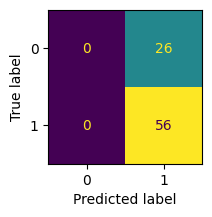

In [12]:
fig, ax = plt.subplots(figsize=(2, 2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)